In [1]:
%matplotlib inline
import torch
from torch import nn
import d2l_torch as d2l
import pandas as pd
import numpy as np

In [2]:
train_data = pd.read_csv('../data/kaggle_house/train.csv')
test_data = pd.read_csv('../data/kaggle_house/test.csv')

### 前4个样本的前4个特征、后2个特征和标签（SalePrice）

In [21]:
# http://zh.gluon.ai/chapter_deep-learning-basics/kaggle-house-price.html#
# https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

In [3]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [4]:
# 在从数据集中删除ID，同时把训练和测试数据集合并起来
# 合并起来的原因是：为了在整个数据集上进行归一化
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [5]:
all_features.shape

(2919, 79)

In [6]:
all_features.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [7]:
all_features = all_features.loc[:,
               ["MSSubClass", "LotFrontage", "LotArea", "HouseStyle", "YearBuilt", "RoofStyle",
                "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "GrLivArea",
                "BsmtFullBath",
                "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",
                "GarageCars", "WoodDeckSF", "OpenPorchSF"]]
print(all_features.shape)
print(all_features.columns)

(2919, 24)
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'HouseStyle', 'YearBuilt',
       'RoofStyle', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF'],
      dtype='object')


In [8]:

# 存在缺失值，这里的原始数据用NAN表示缺失。看看是否有nan值，也就是缺失值
# 看看是否有nan值，也就是缺失值
print(np.any(all_features.isnull()))
# 返回True，说明有缺失值
# 一、数值特征：将所有缺失的值替换为相应特征的平均值。 通过将特征重新缩放到零均值和单位方差来标准化数据:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

# 二、离散值特征：用一次独热编码替换
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)

True


In [9]:
# 从pandas格式中提取NumPy格式，并将其转换为张量表示
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
train_labels = torch.tensor(train_data["SalePrice"].values.reshape(-1, 1),
                            dtype=torch.float32)
print(train_features.shape)  # 两个维度，0维：样本数；1维：特征数
print(train_labels.shape)  # 标签

# 训练
loss = nn.MSELoss()  # 均方损失函数
in_features = train_features.shape[1]  # 特征数

torch.Size([1460, 38])
torch.Size([1460, 1])


In [10]:
def try_gpu():
    return torch.device('cuda:0')

In [11]:
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 32),
                        nn.ReLU(),
                        nn.Linear(32, 16),
                        nn.ReLU(),
                        nn.Linear(16, 1))  # 多层感知机
    return net

In [12]:
def log_rmse(net, features, labels):
    net(features)
    # torch.clamp函数：将输入input张量每个元素的夹紧到区间 [min,max][min,max]，并返回结果到一个新张量。这里是区间1~无穷大
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    # 将标签和预测值取对数，并送入rmse中
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()  # 返回数值，而不是tensor

In [13]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)  # 将训练数据打包成batch_size大小，并可迭代取出
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            X = X.to(try_gpu())
            y = y.to(try_gpu())

            optimizer.zero_grad()  # 梯度清零
            l = loss(net(X), y)  # 计算损失，注意：pytorch会自动将向量转换成标量，以便反向传播计算导数
            l.backward()  # 反向传播：计算梯度
            optimizer.step()  # 更新参数
        train_ls.append(log_rmse(net, train_features.to(try_gpu()), train_labels.to(try_gpu())))  # 将训练的对数rmse保存下来，以便返回
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features.to(try_gpu()), test_labels.to(try_gpu())))  # 将测试的对数rmse保存下来，以便返回
    return train_ls, test_ls

In [14]:
# K折交叉验证：
def get_k_fold_data(k, i, X, y):  # i表示第几折
    assert k > 1
    fold_size = X.shape[0] // k  # 分成k份,每折的大小
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)  # slice() 函数实现切片对象，主要用在切片操作函数里的参数传递。
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [15]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):  # 做k次
        data = get_k_fold_data(k, i, X_train, y_train)  # 获取训练集和验证集
        net = get_net()  # 模型
        net = net.to(try_gpu())

        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)  # 得到损失，注意：data传入的是列表
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:  # 画第1折训练的曲线
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.187003, valid log rmse 0.165398
fold 2, train log rmse 0.173257, valid log rmse 0.192895
fold 3, train log rmse 0.173836, valid log rmse 0.178357
fold 4, train log rmse 0.175568, valid log rmse 0.193840
fold 5, train log rmse 0.171066, valid log rmse 0.195615
5-折验证: 平均训练log rmse: 0.176146, 平均验证log rmse: 0.185221


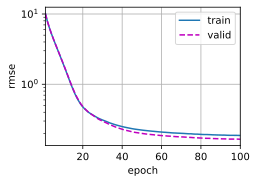

In [16]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 0.1, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [17]:
def train_and():
    net = get_net()
    net = net.to(try_gpu())
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    torch.save(net.state_dict(), 'model/kaggle_house_jupyter.pth')

train log rmse 0.175169


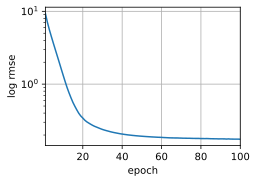

In [18]:
train_and()

In [19]:
def and_pred():
    net = get_net()
    net.load_state_dict(torch.load('model/kaggle_house_jupyter.pth'))
    net = net.to(try_gpu())
    preds = net(test_features.to(try_gpu())).cpu().detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv(r'../data/kaggle_house/submission.csv', index=False)  
    # 将预测的房价结果保存下来
    print('save result:data/kaggle_house/submission.csv')

In [20]:
and_pred()

save result:data/kaggle_house/submission.csv


## 优秀案例

第二和第七：https://www.bilibili.com/video/BV1rh411m7Hb?from=search&seid=14820697425740410884
<br>第三h2o：https://www.kaggle.com/wuwawa/automl-using-h2o
<br>第四 随机森林：https://www.kaggle.com/jackzh/the-4th-place-approach-random-forest

![经验](draw/kaggle_house_price_summary.png)

![经验](draw/kaggle_house_price_summary2.png)